### Step 1: Identify Matching Categories
Here are some potential matches between the datasets based on common military categories:

- **Tanks**
  - **Ukraine Claims**: `tanks`
  - **Official Data**: May correspond to a combination of categories like `Russia_Destroyed` tanks or similar.
- **Aircraft (Planes and Helicopters)**
  - **Ukraine Claims**: `planes`, `helicopters`
  - **Official Data**: Look for `Russia_Destroyed` planes and helicopters.
- **Artillery Systems**
  - **Ukraine Claims**: `artillery_systems`
  - **Official Data**: Check for a similar `Russia_Destroyed` artillery category.
- **Air Defense Equipment**
  - **Ukraine Claims**: `air_defense_equipment`
  - **Official Data**: Corresponds to destroyed air defense systems.



|   | Date       | Tanks (Ukraine Claims) | Artillery Systems (Ukraine Claims) | Combined Aircraft (Ukraine Claims) | Russia_Tanks | Russia_Artillery | Russia_Aircraft |
|---|------------|------------------------|------------------------------------|------------------------------------|--------------|------------------|-----------------|
| 0 | 2022-02-24 | 0                      | 0.0                                | 13                                 | 1            | 0                | 4               |
| 1 | 2022-02-25 | 0                      | 0.0                                | 17                                 | 2            | 4                | 5               |
| 2 | 2022-02-27 | 150                    | 50.0                               | 53                                 | 9            | 4                | 6               |
| 3 | 2022-02-28 | 191                    | 74.0                               | 58                                 | 41           | 9                | 7               |
| 4 | 2022-03-01 | 198                    | 77.0                               | 58                                 | 44           | 10               | 9               |

### Columns Explanation:
- **Tanks (Ukraine Claims)**: Number of Russian tanks Ukraine claims to have destroyed on that date.
- **Artillery Systems (Ukraine Claims)**: Number of Russian artillery systems Ukraine claims to have destroyed.
- **Combined Aircraft (Ukraine Claims)**: Total number of Russian aircraft (planes and helicopters) Ukraine claims to have destroyed.
- **Russia_Tanks**, **Russia_Artillery**, **Russia_Aircraft**: Officially documented numbers of Russian tanks, artillery, and aircraft destroyed.

This merged view allows for direct comparison between reported Ukrainian claims and the officially documented losses.

In [153]:
# Load the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

merged_data = pd.read_csv('final_merged_RussianLosses_comparison.csv')

# Print all column names to verify the correct ones
print(merged_data.columns)


Index(['Date', 'tanks', 'artillery_systems', 'combined_aircraft', 'personnel',
       'cars_and_tank_trucks', 'air_defense_equipment', 'special_equipment',
       'Russia_Tanks', 'Russia_Artillery', 'Russia_Aircraft',
       'Russia_Infantry', 'Russia_Vehicles', 'Russia_Antiair',
       'Russia_Engineering'],
      dtype='object')


# Step 1: Calculate Differences and Ratios

First, we'll add columns for the absolute differences and ratios between Ukrainian claims and the official data for each category.

In [154]:
# Define the categories for analysis and their corresponding official columns
categories = {
    'tanks': 'Russia_Tanks',
    'artillery_systems': 'Russia_Artillery',
    'combined_aircraft': 'Russia_Aircraft',  
    'personnel': 'Russia_Infantry', 
    'cars_and_tank_trucks': 'Russia_Vehicles',
    'air_defense_equipment': 'Russia_Antiair',
    'special_equipment': 'Russia_Engineering'
}

# Display the updated dataset with new columns
print(merged_data.head())
# Calculating differences and ratios for each category
for category, official_col in categories.items():
    merged_data[f'{category}_diff'] = merged_data[category] - merged_data[official_col]
    merged_data[f'{category}_ratio'] = merged_data[category] / merged_data[official_col].replace(0, 1)  # Avoid division by zero

# Display the updated dataset with new columns
print(merged_data[['Date'] + [f'{cat}_diff' for cat in categories] + [f'{cat}_ratio' for cat in categories]].head())



         Date  tanks  artillery_systems  combined_aircraft  personnel  \
0  2022-02-24      0                  0                 13        800   
1  2022-02-25      0                  0                 17       2800   
2  2022-02-27    150                 50                 53       4500   
3  2022-02-28    191                 74                 58       5300   
4  2022-03-01    198                 77                 58       5710   

   cars_and_tank_trucks  air_defense_equipment  special_equipment  \
0                     0                      0                  0   
1                     0                      0                  0   
2                     0                      1                  0   
3                   291                      1                  0   
4                   305                      8                  0   

   Russia_Tanks  Russia_Artillery  Russia_Aircraft  Russia_Infantry  \
0             1                 0                4                3   
1   

In [155]:


replace_original = False  # Set to False to create new columns

# Loop over each category
for category, official_col in categories.items():
    # Calculate the daily increase for each category
    daily_increase_category = merged_data[category].diff()
    daily_increase_official = merged_data[official_col].diff()

    if replace_original:
        # Replace the original columns with the daily increases
        merged_data[category] = daily_increase_category
        merged_data[official_col] = daily_increase_official
        # Remove rows with NaN values
        merged_data.dropna(inplace=True)
    else:
        # Create new columns for the daily increases
        merged_data[f'{category}_daily_increase'] = daily_increase_category
        merged_data[f'{official_col}_daily_increase'] = daily_increase_official
        merged_data.fillna(0, inplace=True)

from scipy import stats
import numpy as np

# Define threshold
threshold = 3  # corresponds to 3 standard deviations

# Loop over each category
for category, official_col in categories.items():
    # Calculate Z-scores
    z_scores_category = np.abs(stats.zscore(merged_data[category]))
    z_scores_official = np.abs(stats.zscore(merged_data[official_col]))

    # Identify outliers
    outliers_category = z_scores_category > threshold
    outliers_official = z_scores_official > threshold

    # Remove outliers
    merged_data = merged_data[~(outliers_category | outliers_official)]

print(merged_data.describe())

             tanks  artillery_systems  combined_aircraft      personnel  \
count   750.000000         750.000000         750.000000     750.000000   
mean   3611.833333        3936.512000         548.614667  182532.154667   
std    1729.941274        3198.317382         115.612236  130227.035152   
min     434.000000         140.000000         160.000000   12000.000000   
25%    2240.500000        1344.500000         471.500000   55632.500000   
50%    3609.500000        2665.000000         597.000000  172620.000000   
75%    4741.750000        6600.250000         631.000000  279777.500000   
max    7087.000000       11356.000000         672.000000  448400.000000   

       cars_and_tank_trucks  air_defense_equipment  special_equipment  \
count            750.000000             750.000000         750.000000   
mean            6377.886667             338.354667         545.640000   
std             3604.973420             210.466770         529.231403   
min              600.000000     

# Step 2: Visualize the Data

To help visualize the differences and ratios, create plots using matplotlib and seaborn.

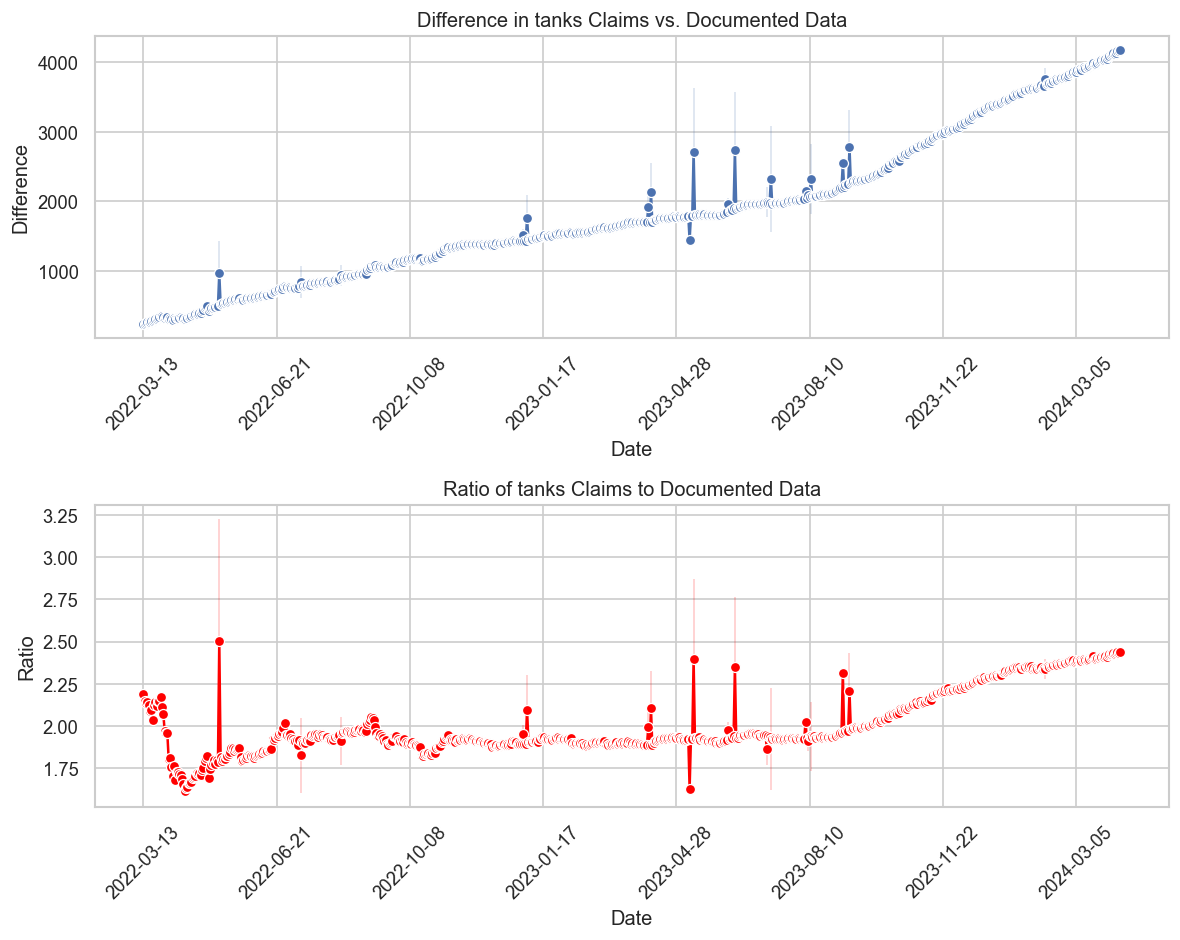

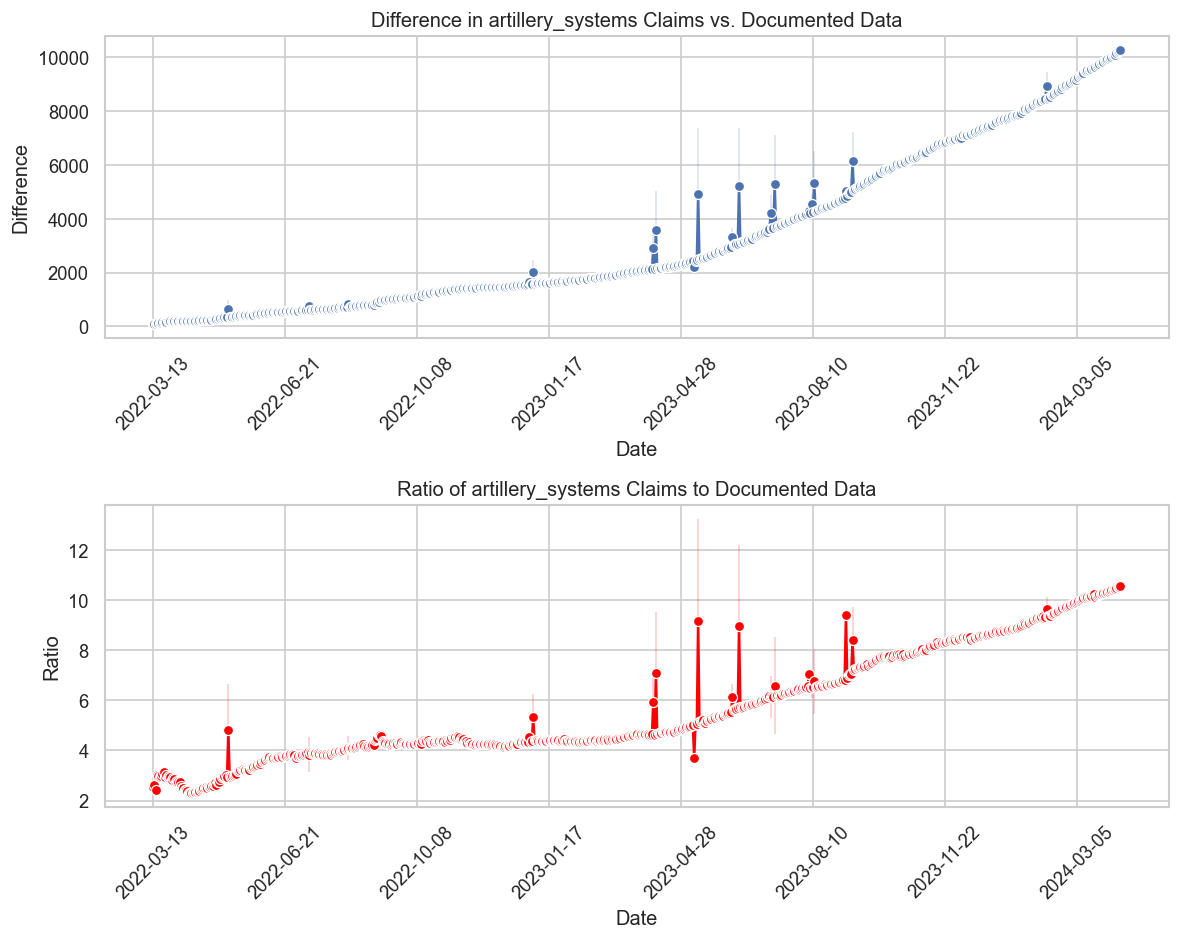

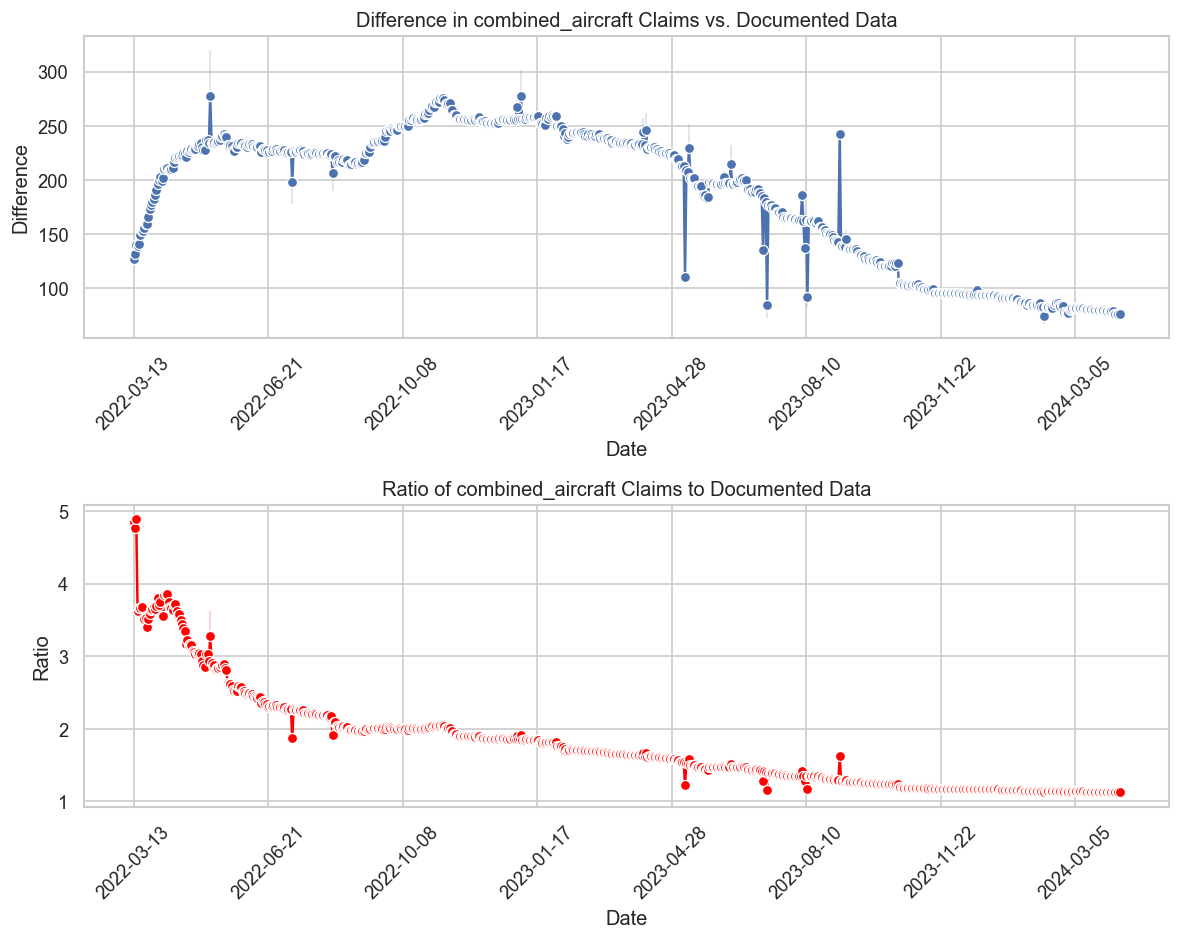

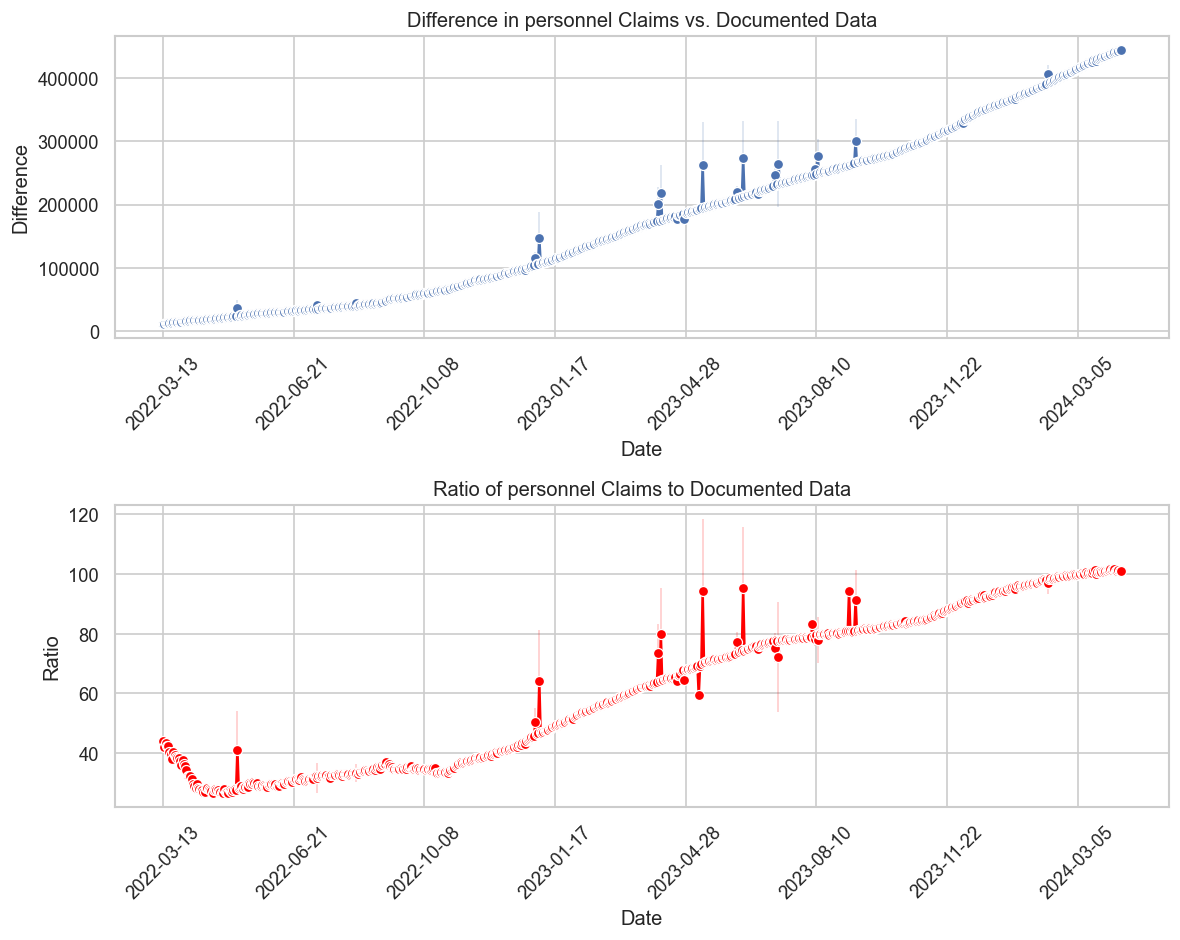

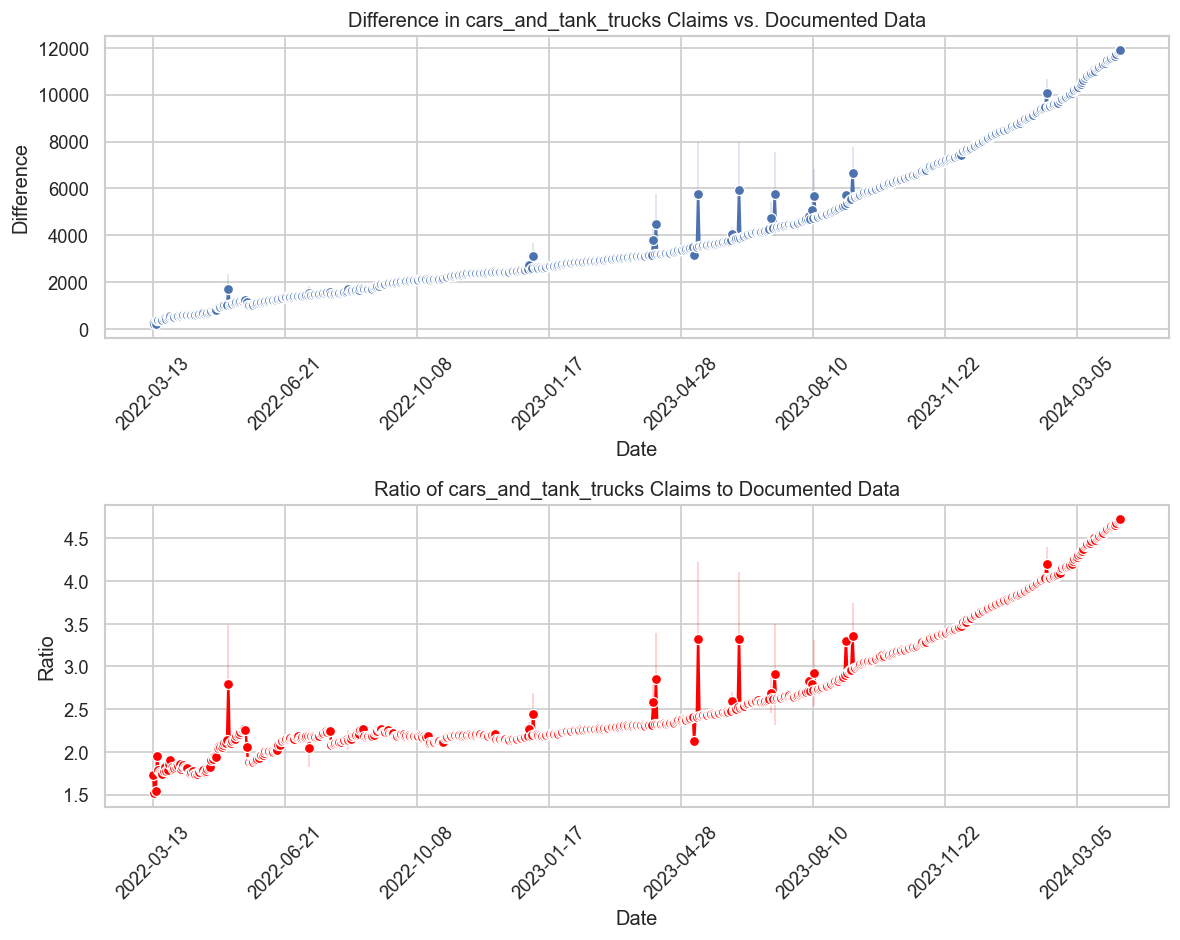

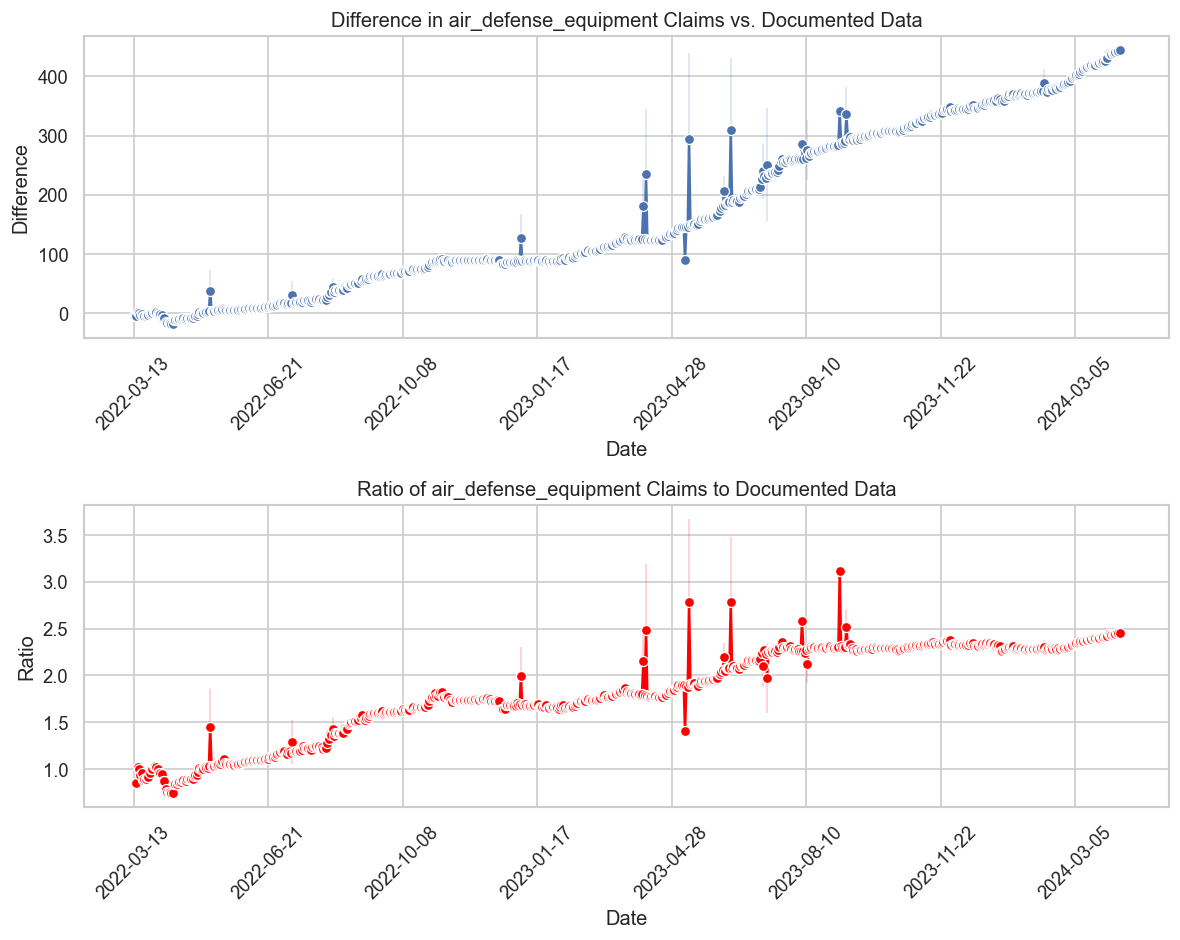

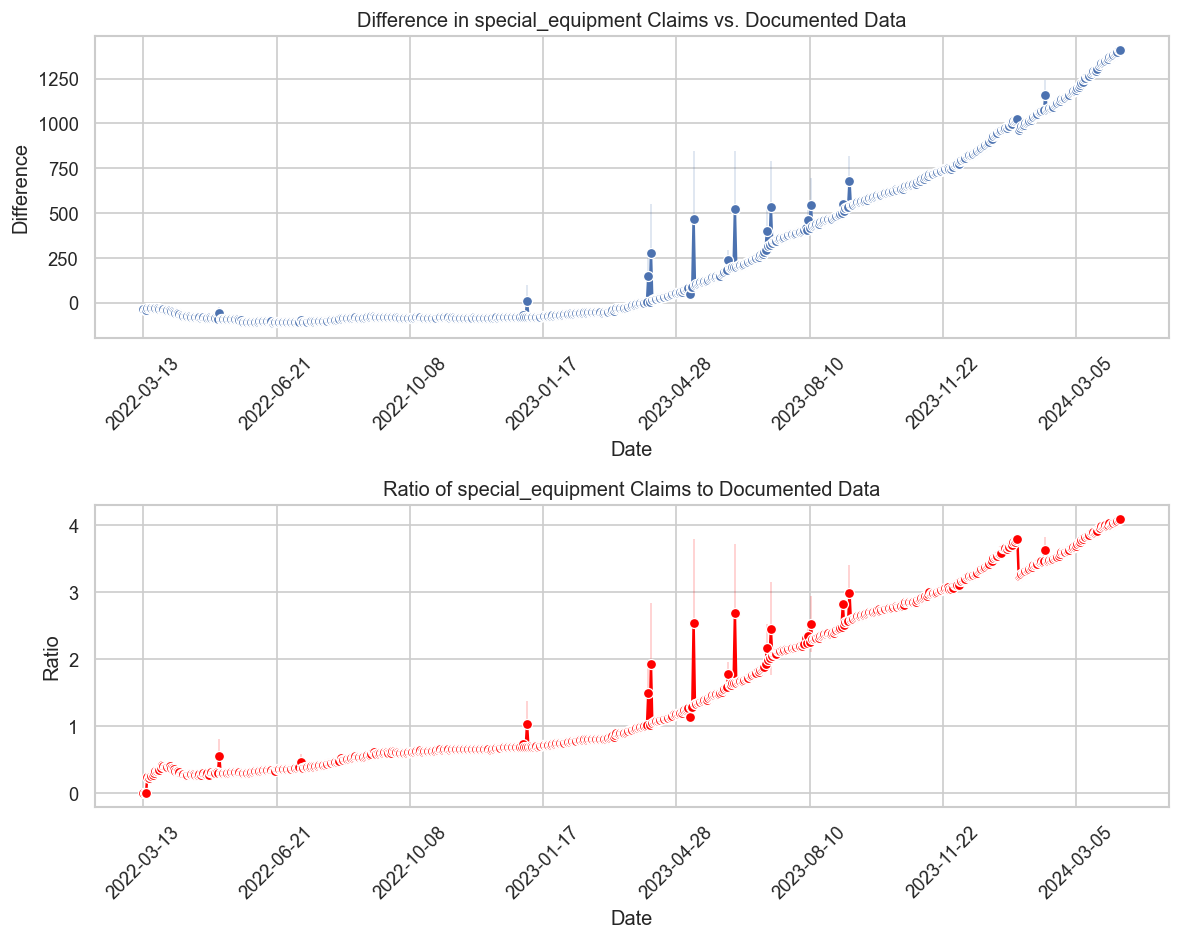

In [156]:


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Function to plot differences and ratios for each category
def plot_data(category):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), dpi=120)

    # Plotting the difference
    sns.lineplot(x='Date', y=f'{category}_diff', data=merged_data, ax=axes[0], marker='o')
    axes[0].set_title(f'Difference in {category} Claims vs. Documented Data')
    axes[0].set_ylabel('Difference')
    axes[0].tick_params(axis='x', rotation=45)
    # Adjust the x-axis to show fewer date labels
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number depending on the dataset size

    # Plotting the ratio
    sns.lineplot(x='Date', y=f'{category}_ratio', data=merged_data, ax=axes[1], marker='o', color='red')
    axes[1].set_title(f'Ratio of {category} Claims to Documented Data')
    axes[1].set_ylabel('Ratio')
    axes[1].tick_params(axis='x', rotation=45)
    # Adjust the x-axis to show fewer date labels
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number depending on the dataset size

    plt.tight_layout()
    plt.show()

# Example usage to plot data for tanks
plot_data('tanks')
plot_data('artillery_systems')
plot_data('combined_aircraft')
plot_data('personnel')
plot_data('cars_and_tank_trucks')
plot_data('air_defense_equipment')
plot_data('special_equipment')



## Correlation Analysis


In [157]:
# Calculating and printing correlations between differences and official counts
for category, official_col in categories.items():
    corr_value = merged_data[category].corr(merged_data[official_col])
    print(f"Correlation between {category} and {official_col}: {corr_value:.2f}")


Correlation between tanks and Russia_Tanks: 0.98
Correlation between artillery_systems and Russia_Artillery: 0.95
Correlation between combined_aircraft and Russia_Aircraft: 0.94
Correlation between personnel and Russia_Infantry: 0.96
Correlation between cars_and_tank_trucks and Russia_Vehicles: 0.91
Correlation between air_defense_equipment and Russia_Antiair: 0.99
Correlation between special_equipment and Russia_Engineering: 0.89


## Lag Analysis Using Cross-Correlation

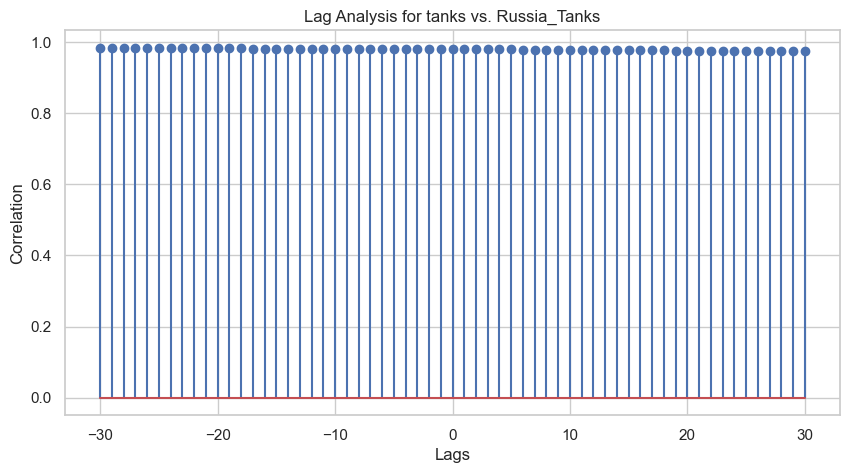

Correlation between tanks and Russia_Tanks


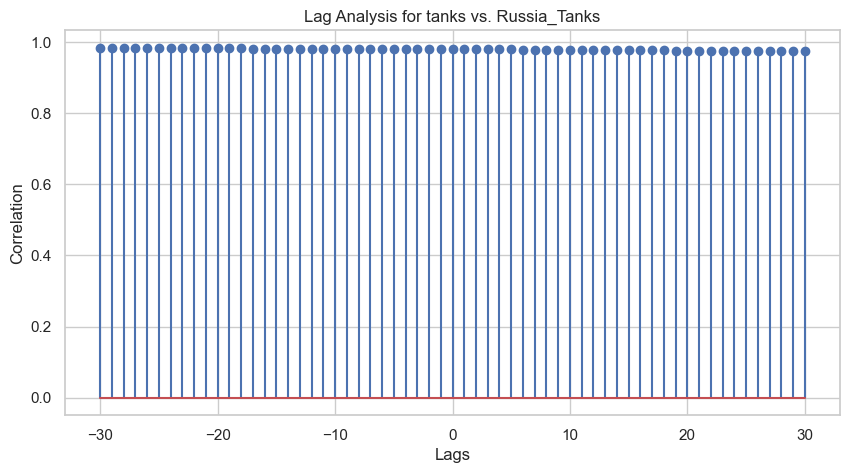

Correlation between artillery_systems and Russia_Artillery


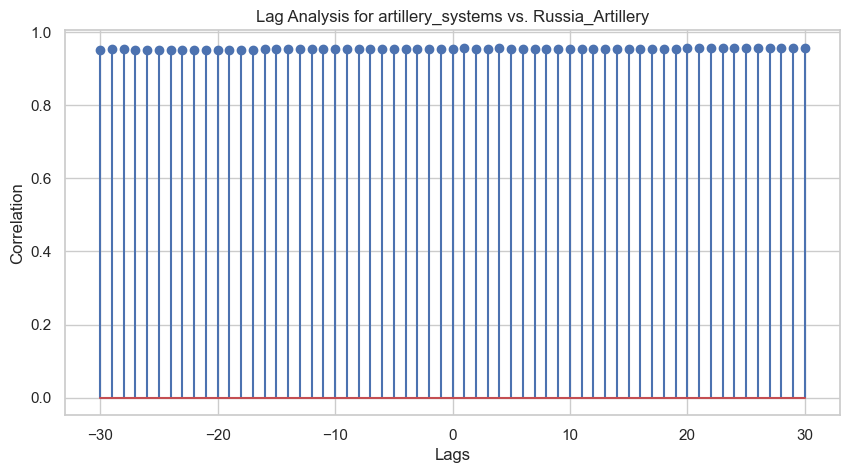

Correlation between combined_aircraft and Russia_Aircraft


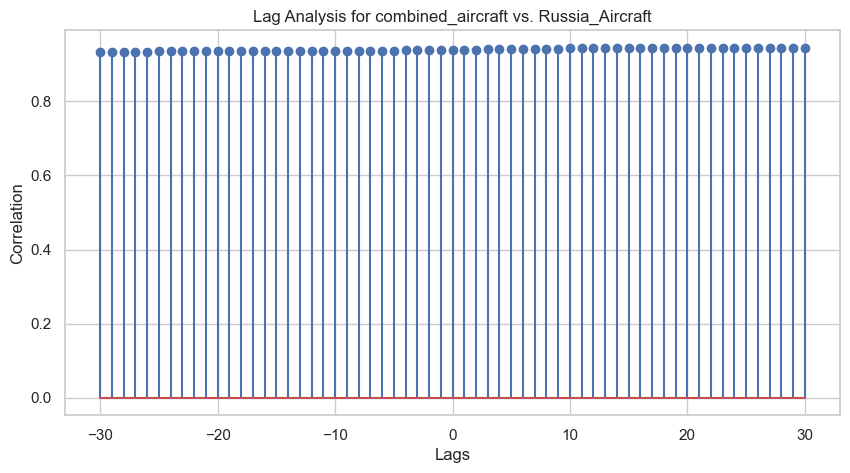

Correlation between personnel and Russia_Infantry


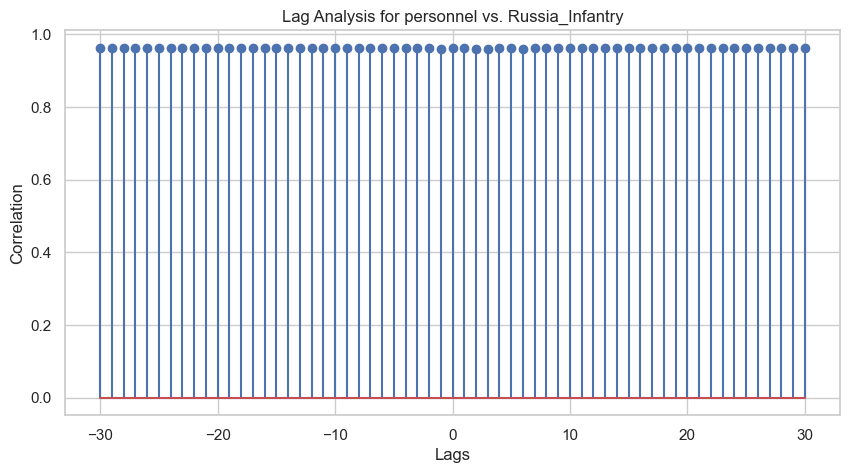

Correlation between cars_and_tank_trucks and Russia_Vehicles


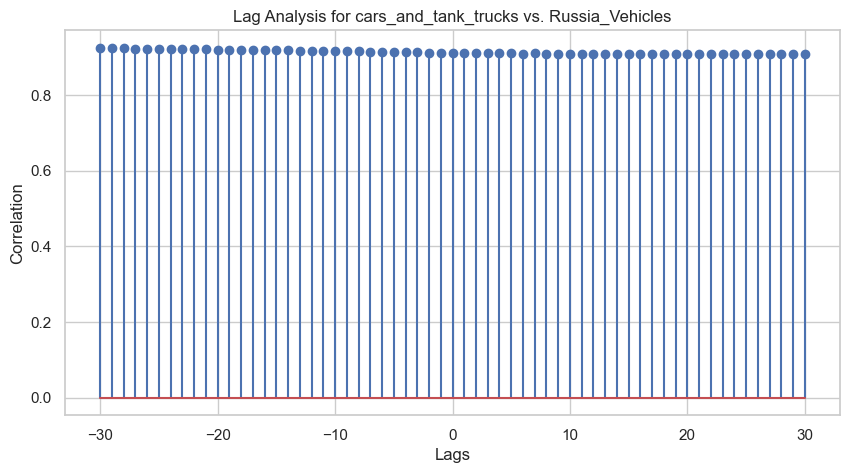

Correlation between air_defense_equipment and Russia_Antiair


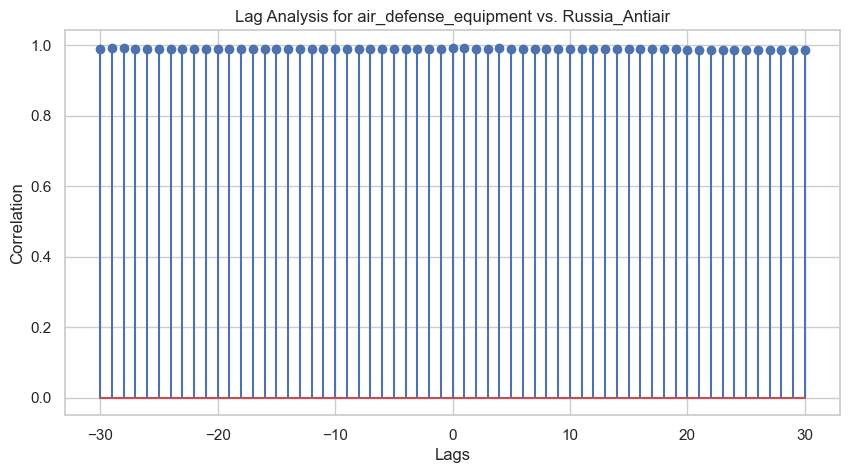

Correlation between special_equipment and Russia_Engineering


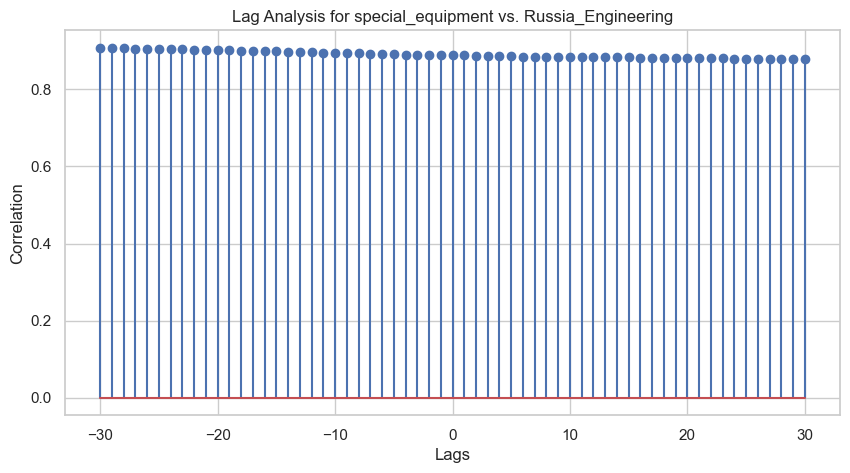

In [158]:
import numpy as np

# Function to perform lag analysis
def lag_analysis(data, category, official_col, max_lag=30):
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = [data[category].corr(data[official_col].shift(lag)) for lag in lags]

    plt.figure(figsize=(10, 5))
    plt.stem(lags, correlations)
    plt.title(f'Lag Analysis for {category} vs. {official_col}')
    plt.xlabel('Lags')
    plt.ylabel('Correlation')
    plt.show()

# Example lag analysis for tanks
lag_analysis(merged_data, 'tanks', 'Russia_Tanks')
for category, official_col in categories.items():
   print(f'Correlation between {category} and {official_col}')
   lag_analysis(merged_data, category,official_col)


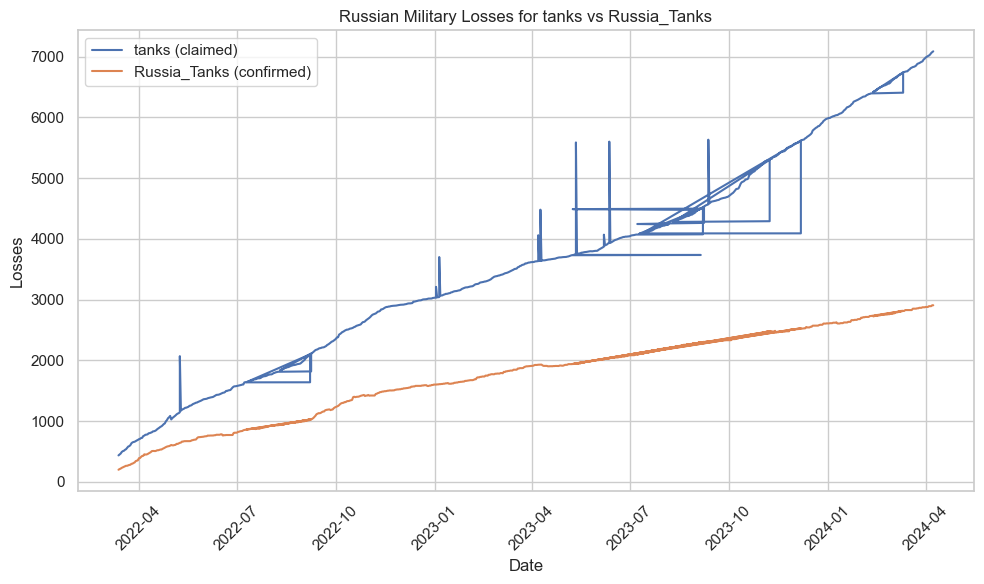

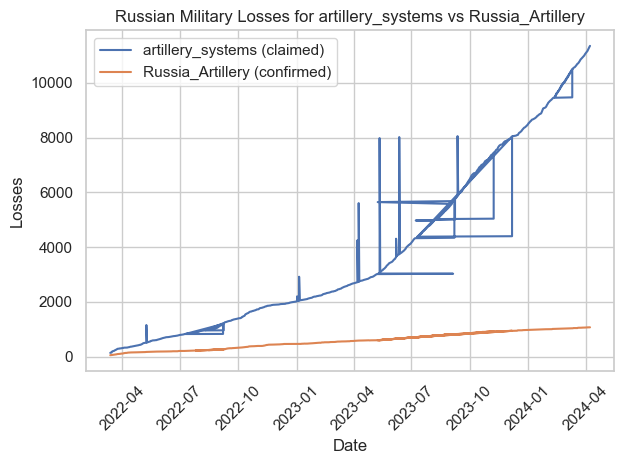

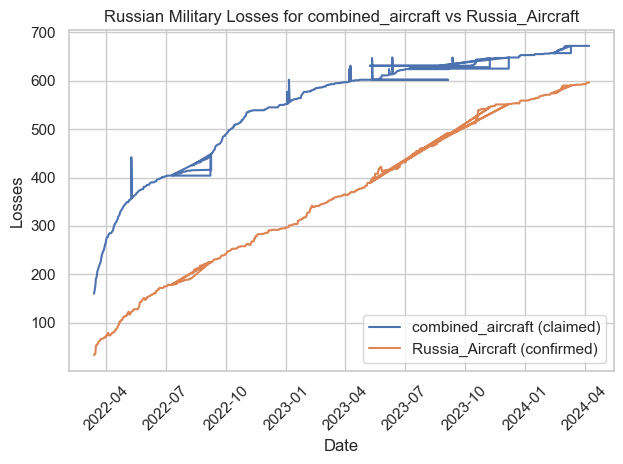

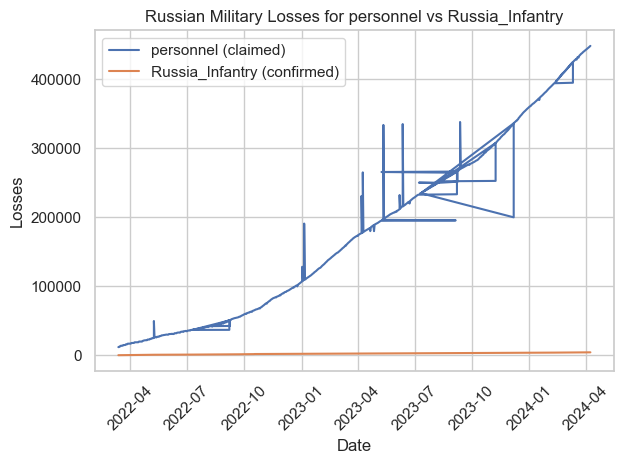

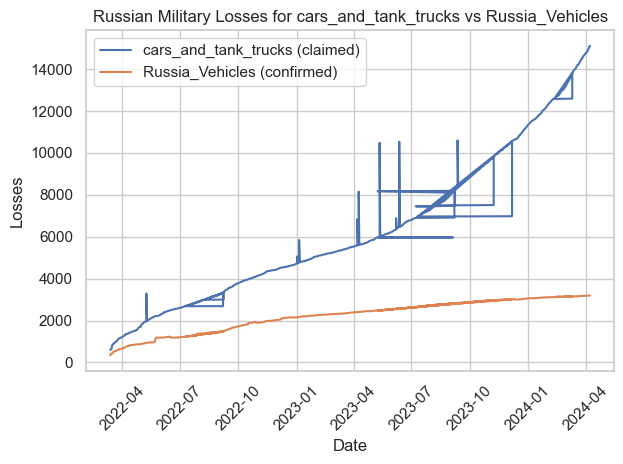

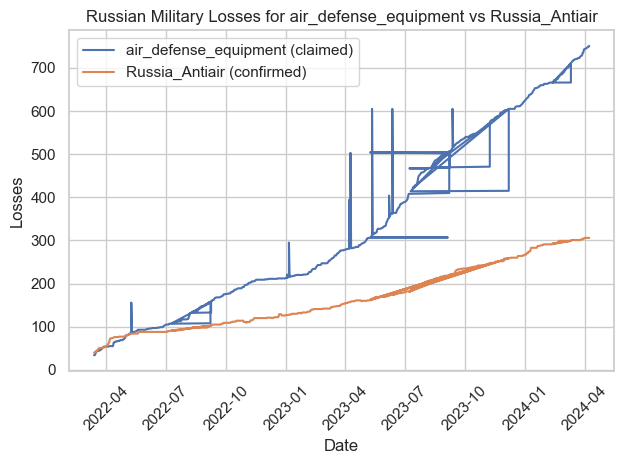

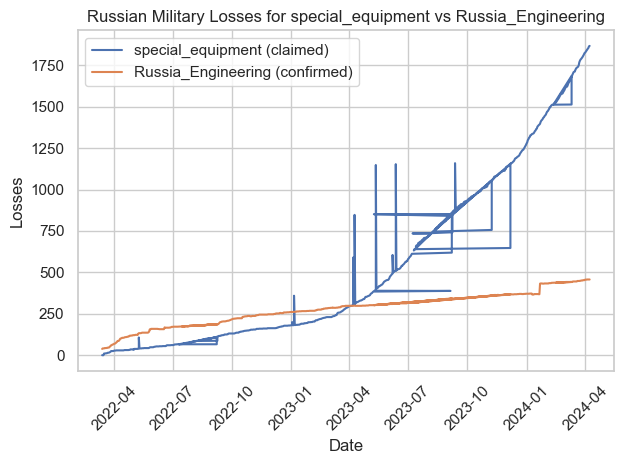

In [164]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 6))
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
for category, official_col in categories.items():
    plt.plot(merged_data['Date'], merged_data[category], label=f'{category} (claimed)')
    plt.plot(merged_data['Date'], merged_data[official_col], label=f'{official_col} (confirmed)')
    plt.title(f'Russian Military Losses for {category} vs {official_col}')
    plt.xlabel('Date')
    plt.ylabel('Losses')
    plt.legend()
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


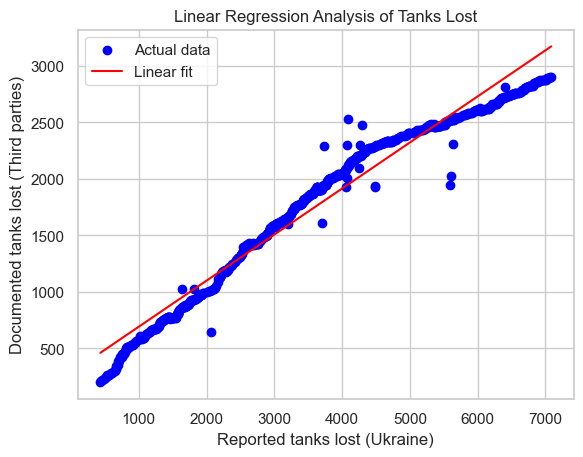

In [160]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Prepare the data
X = merged_data['tanks'].values.reshape(-1, 1)  # Reported losses by Ukraine
y = merged_data['Russia_Tanks'].values  # Documented losses by third parties

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Plotting
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', label='Linear fit')
plt.xlabel('Reported tanks lost (Ukraine)')
plt.ylabel('Documented tanks lost (Third parties)')
plt.title('Linear Regression Analysis of Tanks Lost')
plt.legend()
plt.show()


# Calculate Bias as Percentage Difference

In [161]:
# Calculating percentage difference for tanks as an example
df=merged_data

df['bias_tanks'] = ((df['tanks'] - df['Russia_Tanks']) / df['Russia_Tanks']) * 100

# Display the calculated bias
print(df[['Date', 'tanks', 'Russia_Tanks', 'bias_tanks']].head())


         Date  tanks  Russia_Tanks  bias_tanks
16 2022-03-13    434           198  119.191919
17 2022-03-14    449           209  114.832536
18 2022-03-15    464           217  113.824885
19 2022-03-16    490           229  113.973799
20 2022-03-17    504           237  112.658228


# Time Lag Analysis

/var/folders/57/d8l_pxy12ls5pwj4_d5s30d00000gn/T/ipykernel_21444/1835396902.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(lag_corr)), lag_corr, use_line_collection=True)


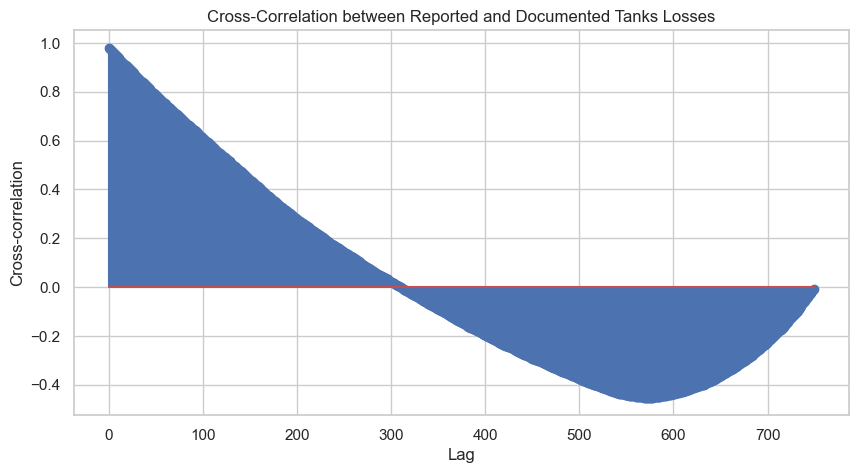

In [162]:
from statsmodels.tsa.stattools import ccf

# Compute cross-correlation
lag_corr = ccf(df['tanks'].dropna(), df['Russia_Tanks'].dropna(), adjusted=False)

# Plot the cross-correlation
plt.figure(figsize=(10, 5))
plt.stem(range(len(lag_corr)), lag_corr, use_line_collection=True)
plt.title('Cross-Correlation between Reported and Documented Tanks Losses')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()


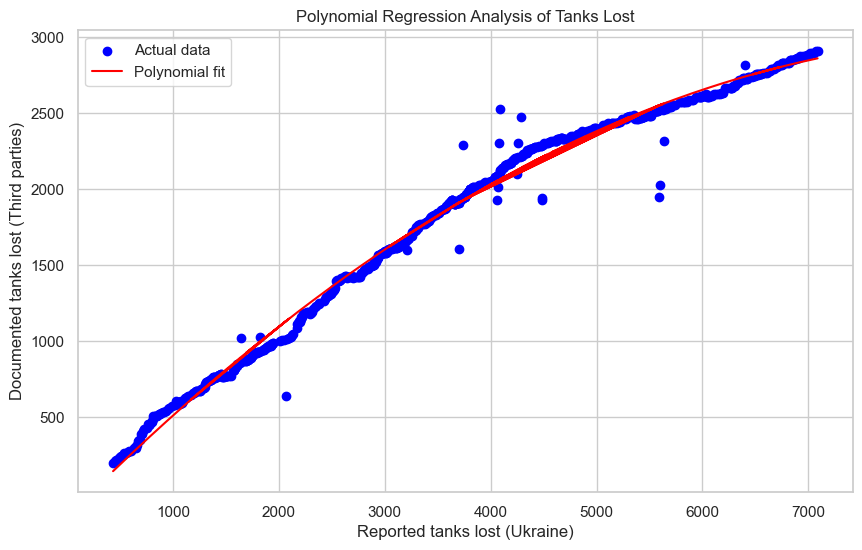

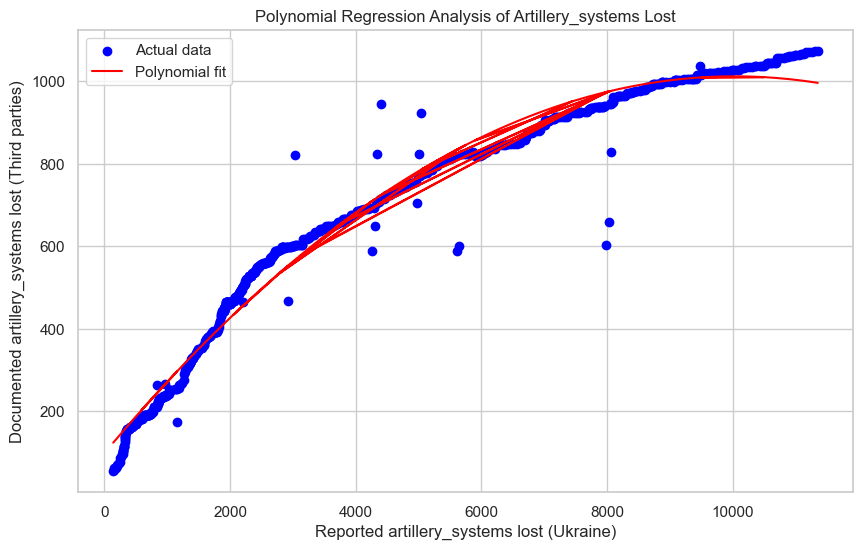

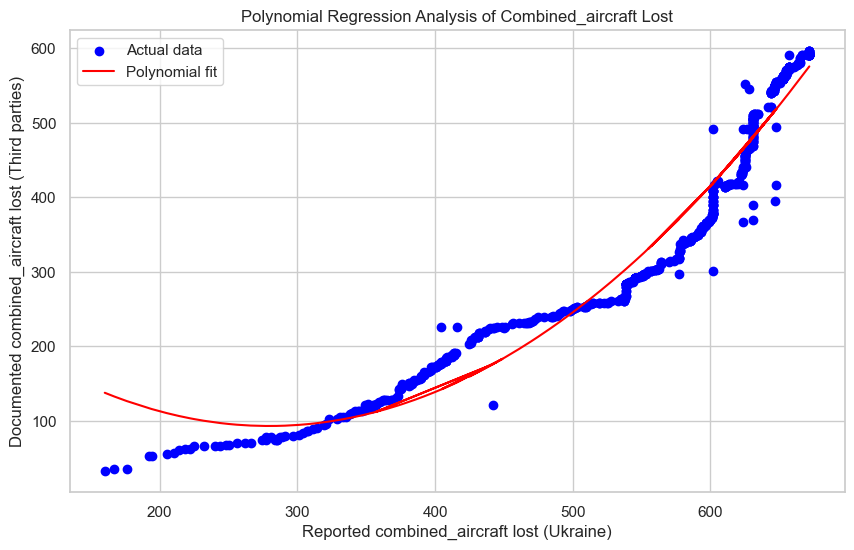

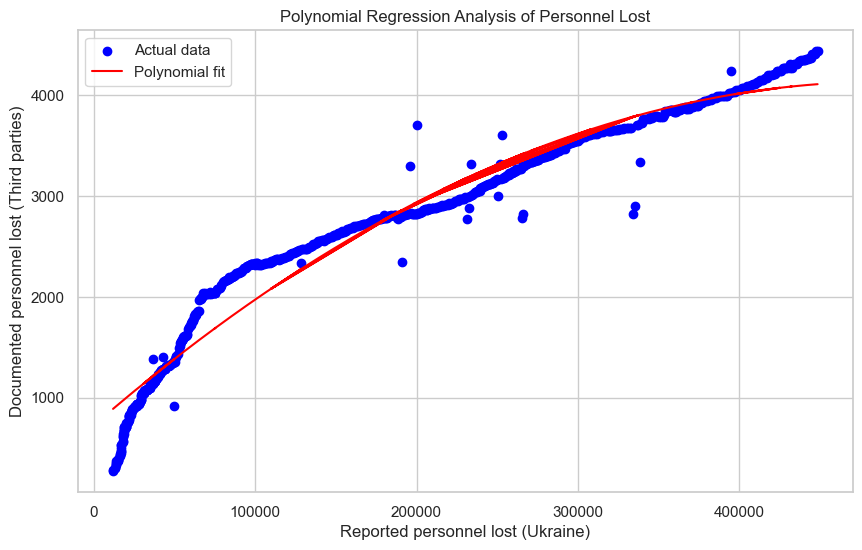

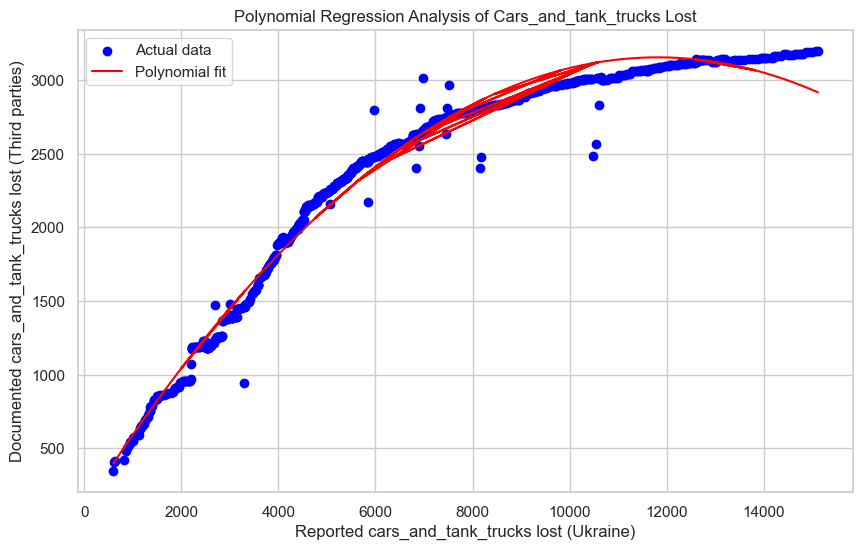

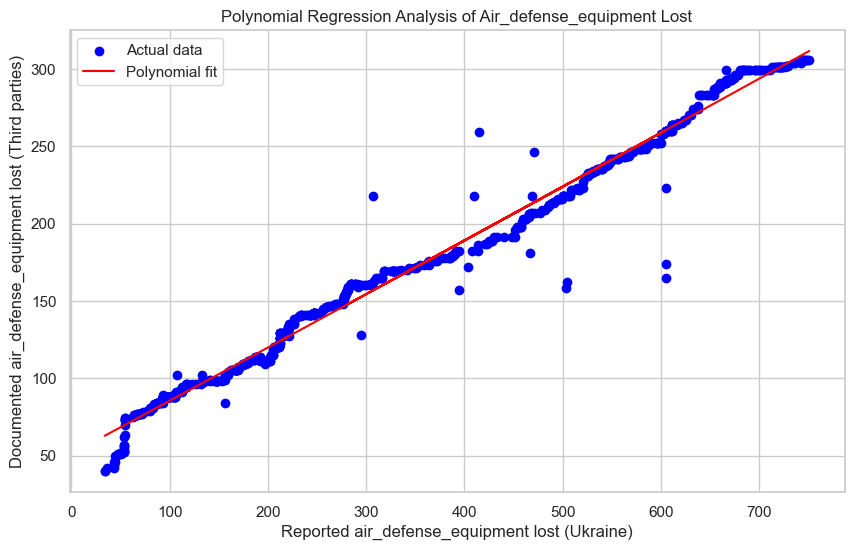

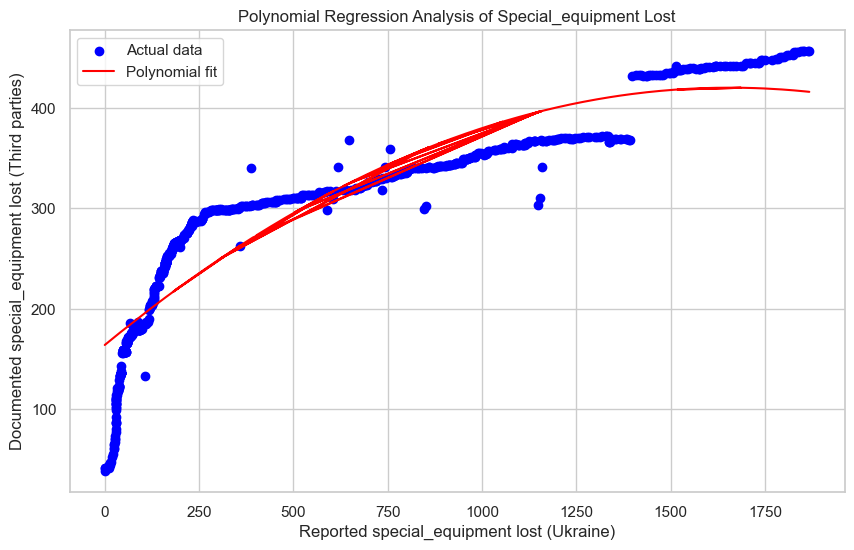

In [163]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

for category, official_col in categories.items():
    # Prepare the data
    X = merged_data[category].values.reshape(-1, 1)  # Reported losses by Ukraine
    y = merged_data[official_col].values  # Documented losses by third parties

    # Transform the input array
    poly = PolynomialFeatures(degree=2)  # Change the degree as needed
    X_poly = poly.fit_transform(X)

    # Create a linear regression model and fit it to the transformed input array
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predictions
    y_pred = model.predict(X_poly)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual data')
    plt.plot(X, y_pred, color='red', label='Polynomial fit')
    plt.xlabel(f'Reported {category} lost (Ukraine)')
    plt.ylabel(f'Documented {category} lost (Third parties)')
    plt.title(f'Polynomial Regression Analysis of {category.capitalize()} Lost')
    plt.legend()
    plt.show()